# Multi-Chain HMC

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

# from visualization import plot_predictive
import seaborn as sns

# import subspace_inference.utils as utils
# from subspace_inference.posteriors import SWAG
# from subspace_inference import models, losses, utils
# from subspace_inference.models import MLP
from swag import data, models, utils, losses
from swag.posteriors import SWAG


from tqdm import tqdm

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

import hamiltorch

%load_ext autoreload
%autoreload 2

/home/izmailovpavel/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

class RegNet(nn.Sequential):
    def __init__(self, dimensions, input_dim=1, output_dim=1, apply_var=True):
        super(RegNet, self).__init__()
        self.dimensions = [input_dim, *dimensions, output_dim]        
        for i in range(len(self.dimensions) - 1):
            self.add_module('linear%d' % i, torch.nn.Linear(self.dimensions[i], self.dimensions[i + 1]))
            if i < len(self.dimensions) - 2:
                self.add_module('relu%d' % i, torch.nn.ReLU())

        if output_dim == 2:
            self.add_module('var_split', SplitDim(correction=apply_var))

#     def forward(self, x):
#         return super().forward(x)

In [3]:
arr = np.load("data.npz") 
x = torch.from_numpy(arr['x'])
f = featurize(x)
y = torch.from_numpy(arr['y']) * 10

x_ = torch.from_numpy(arr['x_'])
f_ = featurize(x_)
y_ = torch.from_numpy(arr['y_']) * 10

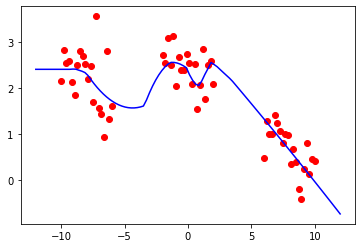

In [4]:
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), y_.data.numpy(), "-b")

## HMC Inference

In [242]:
n_chains = 10
n_samples_per_chain = 500

noise_var = 0.0005
prior_var = .001
pretrain_steps = 3000
    
step_size = 2.e-4
num_steps_per_sample = 1000
tau_out = 1 / noise_var

criterion = torch.nn.functional.mse_loss

all_preds_list = []
all_logprobs_list = []
all_param_lists, param_freq = [], 20

for i in range(1, n_chains):
    
    print(i)
    
    # Pre-Training for better burnin
    net = RegNet(dimensions=[10, 10, 10], input_dim=2)
    tau_list = []
    tau = 1 / prior_var
    for w in net.parameters():
        tau_list.append(tau)
    tau_list = torch.tensor(tau_list)

    optimizer = torch.optim.SGD(net.parameters(), lr=5e-6)
    for epoch in range(pretrain_steps):
        optimizer.zero_grad()
        preds = net(f)
        loss = criterion(preds, y) / (2 * noise_var)
        loss.backward()
        optimizer.step()
    net.loss = 'regression'

    params_init = hamiltorch.util.flatten(net).clone()
    params_hmc = hamiltorch.sample_model(net, f, y, model_loss='regression', params_init=params_init, 
                                         num_samples=n_samples_per_chain, step_size=step_size, 
                                         num_steps_per_sample=num_steps_per_sample, tau_out=tau_out,
                                         tau_list=tau_list
                                        )
    params_hmc = params_hmc[::num_steps_per_sample]
    pred_list, log_prob_list = hamiltorch.predict_model(net, f_, y_, samples=params_hmc, model_loss='regression', 
                                                    tau_out=1., tau_list=tau_list)


    all_preds_list.append(pred_list[None, :])
    all_param_lists.append(torch.stack(params_hmc).numpy().copy()[None, :])
    all_logprobs_list.append(torch.cat(log_prob_list).numpy())
#     break
    
for i, arr in enumerate(all_preds_list):
    np.save("hmc_ensembles_preds_new4_chain{}".format(i), arr)
for i, arr in enumerate(all_param_lists):
    np.save("hmc_ensembles_params_new4_chain{}".format(i), arr)
for i, arr in enumerate(all_logprobs_list):
    np.save("hmc_ensembles_logprobs_new4_chain{}".format(i), arr)

1
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:12:09 | 0d:00:00:00 | #################### | 500/500 | 0.69       
Acceptance Rate 0.68
2
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:12:06 | 0d:00:00:00 | #################### | 500/500 | 0.69       
Acceptance Rate 0.67
3
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:12:02 | 0d:00:00:00 | #################### | 500/500 | 0.69       
Acceptance Rate 0.70
4
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:12:04 | 0d:00:00:00 | #################### | 500/500 | 0.69       
Acceptance Rate 0.64
5
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:12:05 | 0d:00:00:00 | #

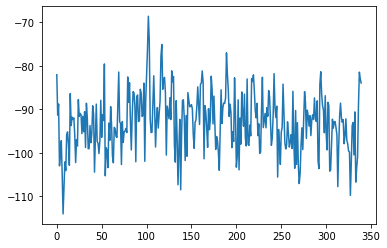

In [243]:
plt.plot(all_logprobs_list[0])

(-1.0, 3.5)

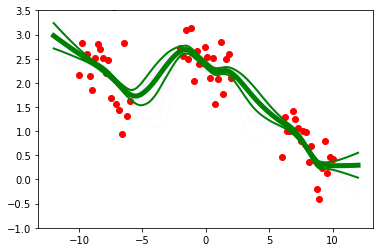

In [253]:
# all_preds = np.vstack([np.load("preds2_{}.npy".format(i)) for i in range(n_chains)])
all_preds = []
for chain in range(8, 9):
    chain_preds = np.load("hmc_ensembles_preds_new4_chain{}.npy".format(chain))
    all_preds.append(chain_preds[0])
all_preds = np.concatenate(all_preds)

pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + pred_std
pred_lower = pred_mean - pred_std

# plt.plot(x_ , all_preds[0, :, 0], '--k');
plt.plot(x_ , all_preds[::10, :, 0].T, '-b',alpha=0.01);
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
# plt.plot(x_.data.numpy(), y_.data.numpy(), "--b")
plt.plot(x_.data.numpy(), pred_mean, "-g", lw=5)
plt.plot(x_.data.numpy(), pred_lower, "-g", lw=2)
plt.plot(x_.data.numpy(), pred_upper, "-g", lw=2)
plt.ylim(-1., 3.5)

(-1.0, 3.5)

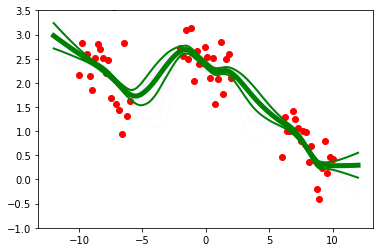

In [274]:
# all_preds = np.vstack([np.load("preds2_{}.npy".format(i)) for i in range(n_chains)])
all_preds = []
for chain in range(8, 9):
    chain_preds = np.load("hmc_ensembles_preds_new4_chain{}.npy".format(chain))
    all_preds.append(chain_preds[0])
all_preds = np.concatenate(all_preds)

pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + pred_std
pred_lower = pred_mean - pred_std

# plt.plot(x_ , all_preds[0, :, 0], '--k');
plt.plot(x_ , all_preds[::10, :, 0].T, '-b',alpha=0.01);
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
# plt.plot(x_.data.numpy(), y_.data.numpy(), "--b")
plt.plot(x_.data.numpy(), pred_mean, "-g", lw=5)
plt.plot(x_.data.numpy(), pred_lower, "-g", lw=2)
plt.plot(x_.data.numpy(), pred_upper, "-g", lw=2)
plt.ylim(-1., 3.5)

## Convergence Diagnostics

In [299]:
all_chain_preds = []
all_chain_means, all_chain_vars = [], []
N = 300
Burnin = 20
for chain in range(9):
    chain_preds = np.load("hmc_ensembles_preds_new4_chain{}.npy".format(chain))[0, :, :, 0]
    chain_preds = chain_preds[Burnin:N]
    all_chain_preds.append(chain_preds)
    chain_var = np.std(chain_preds, axis=0)**2
    chain_mean = np.mean(chain_preds, axis=0)
    all_chain_means.append(chain_mean)
    all_chain_vars.append(chain_var)
    
    

all_chain_means = np.vstack(all_chain_means)
all_chain_vars = np.vstack(all_chain_vars)
    
M = len(all_chain_means)
b_mean = all_chain_means.mean(axis=0)

B = N / (M - 1) * np.sum((all_chain_means - b_mean[None, :])**2, axis=0)
W = np.sum(all_chain_vars, axis=0) / M

In [302]:
V_hat = (N-1) / N * W + 1 / N * B

In [330]:
np.sqrt(V_hat / W).std()

0.008842311

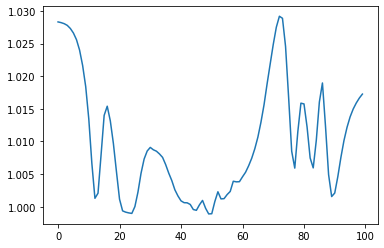

In [306]:
plt.plot(np.sqrt(V_hat / W))

In [164]:
np.sqrt(V_hat / W)

array([1.0048872 , 1.0053493 , 1.005483  , 1.0055403 , 1.0058092 ,
       1.0061886 , 1.0066518 , 1.0070181 , 1.0073026 , 1.0072244 ,
       1.0067419 , 1.0060894 , 1.005271  , 1.0043087 , 1.0027633 ,
       1.0013769 , 1.0004535 , 1.0000887 , 1.000544  , 1.0015379 ,
       1.0023597 , 1.003035  , 1.0039287 , 1.0048095 , 1.006658  ,
       1.0079008 , 1.0076648 , 1.0067843 , 1.0060327 , 1.0055317 ,
       1.0053122 , 1.0046314 , 1.0036589 , 1.0030686 , 1.0018873 ,
       1.0010196 , 1.0001714 , 0.9999724 , 0.99984074, 1.0002112 ,
       1.0011407 , 1.0013765 , 1.0032986 , 1.0054592 , 1.0044287 ,
       1.0032731 , 1.0023528 , 1.0017828 , 1.0030165 , 1.0023875 ,
       1.0016805 , 1.001933  , 1.0039744 , 1.0051577 , 1.0062114 ,
       1.0052581 , 1.003944  , 1.0024637 , 1.0033045 , 1.0048372 ,
       1.0061854 , 1.0069698 , 1.0066894 , 1.0068852 , 1.0064985 ,
       1.0063202 , 1.0056763 , 1.0049155 , 1.0041112 , 1.004215  ,
       1.0043117 , 1.0038214 , 1.0036451 , 1.0037082 , 1.00371

In [324]:
all_params_lists = []
for i in range(9):
    chain_params = np.load("hmc_ensembles_params_new4_chain{}.npy".format(i))
    all_params_lists.append(chain_params[0, :])
all_param_lists = np.concatenate(all_params_lists, axis=0)
all_params_split = []
offset = 0

for p in net.parameters():
    p_numel = p.numel()
    p_shape = p.shape
    
    params = all_param_lists[:, offset:offset+p_numel]
    offset += p_numel
    all_params_split.append(params)

-0.015213695
0.26796785
0.011066556
0.28016546
0.0076567833
0.25166824
0.06996705
0.31995055
0.015395301
0.2614979
0.118777305
0.31833676
0.19915722
0.40266344
0.40595543
0.2363913


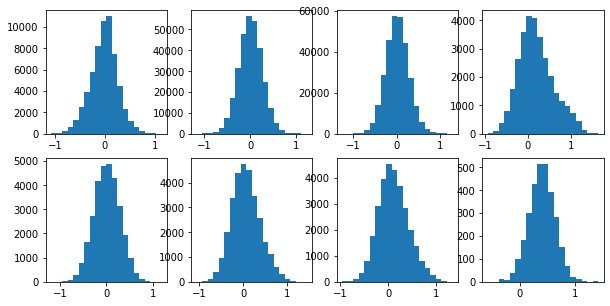

In [326]:
_, arr = plt.subplots(2, 4, figsize=(10, 5))

for layer in range(4):
    for wb in range(2):
        i = layer*2 + wb
        arr[wb, layer].hist(all_params_split[i].reshape(-1), bins=20)
        print(all_params_split[i].mean())
        print(all_params_split[i].std())
#         arr[wb, layer].hist(prior_samples, bins=20)
#         arr[wb, layer].set_xlim(-5, 5.)
        

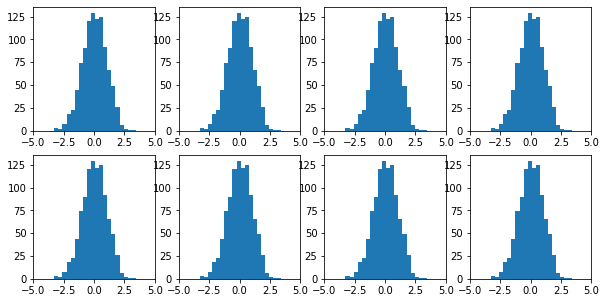

In [115]:
_, arr = plt.subplots(2, 4, figsize=(10, 5))
prior_samples = np.random.normal(0, 1., 1000)#np.sqrt(prior_var), 1000)

for layer in range(4):
    for wb in range(2):
        i = layer*2 + wb
        arr[wb, layer].hist(prior_samples, bins=20)
        arr[wb, layer].set_xlim(-5, 5.)
        